In [3]:
########################### Libraries ####################################
import astropy
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from astropy.coordinates.angle_utilities import hms_to_degrees, dms_to_degrees
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u
import re
import json
from collections import Counter
from operator import itemgetter
import scipy
from scipy.signal import argrelextrema
from astroML.time_series import lomb_scargle
from gatspy.periodic import LombScargleFast

In [4]:
#ОКПЗ
data = astropy.io.ascii.read('gcvs5.txt', data_start=2, delimiter='|')
data = data.to_pandas()
datalistt=data['Max'].tolist()
datalist=data['Min I'].tolist()

In [5]:
data.head()

,NNo,GCVS,J2000.0,Type,Max,Min I,Min II,Epoch,Year,Period,M-m,Spectrum,References,Other desig. p.m.(as/yr) Epoch Ident. New type GCVS
0,010001,R And *,002401.95 +383437.3,M,5.8,15.2,NaN,V |53820.,NaN,409.2,38,"S3,5e-S8,8e(M7e)",HIP 00002,|-0.016 -0.035|2000.0 | |Hip |M ...
1,010002,S And *,004243.1 +411605.0,SNI,5.8,< 16.,NaN,V |09775.,1885,NaN,NaN,(SNI),V 377 V 338,=M31 V0894| |1885.67 | |Lit. ...
2,010003,T And,002223.15 +265945.8,M,7.7,14.5,NaN,V |50854.,NaN,281.0,46,M4e-M7.5e,00001 00002,|-0.007 -0.003|2000.0 | |Tyc2 |M ...
3,010004,U And,011529.70 +404308.4,M,9.0,15.0,NaN,V |49564.,NaN,347.7,40,M6e,00001 00002,|+0.009 -0.011|2000.0 | |UCAC2 |M ...
4,010005,V And,005006.28 +353910.1,M,9.0,15.2,NaN,V |51528.,NaN,256.4,45,M2e-M3e,00001 00002,|-0.007 -0.007|2000.0 | |NPM |M ...


### GCVS input ('Max'  and 'Min I' columns) corrections

In [6]:
name=datalistt[39]# save strange nan?
for i in range(len(datalist)):
    try:
        if datalist[i][0]=='<':
            datalist[i]=datalist[i][2:]
        if datalist[i][-1]==':':
            datalist[i]=datalist[i][:4]
        if datalist[i][0]=='(':
            datalist[i]=100
    except:
        print(i)
        
for i in range(len(datalistt)):
    try:
        if datalistt[i]==datalistt[39]:
            datalistt[i]=0
        if datalistt[i][0]=='|':
            datalistt[i]=datalistt[1][1:]
    except:
        print(i)        

17
39
40
77
147
153
261
812
835
931
953
1209
1495
1567
1588
1946
2120
2149
2155
2163
2316
2395
2528
2821
2856
3287
3431
3952
4113
4155
5118
5144
5287
5299
5330
5340
5464
5465
5553
5745
5809
5810
6129
6130
6157
6178
6185
6210
6304
6616
6617
6812
7207
7236
7243
7526
7531
7545
7548
7604
7754
7755
7942
7959
7967
8029
8404
8445
8555
8558
8647
8888
8895
8909
8964
9610
9880
9907
10020
10063
10115
10140
10145
10477
10478
10531
10824
10866
10869
10929
10934
10937
10938
10939
11343
11472
11570
11636
11646
11672
11858
11890
11903
12316
12320
12358
12440
12486
12512
12530
12659
12700
12872
13353
13437
13622
13866
14079
14189
14191
14243
14259
14336
14344
14532
14902
14907
15015
15150
15796
15814
15833
15844
15886
15887
15896
15897
16066
16130
16131
16132
16138
16148
16186
16358
16463
16877
17070
17303
17365
17590
17988
17992
19067
19155
19159
19160
19753
19798
19831
19873
20179
20197
20200
20213
20216
20349
20417
20875
20878
20885
20902
20903
20908
21113
21162
21200
21230
21303
21497
22120
22431
2

 # GCVS analyses  

### Here we remove stars which min mag< 12m

In [7]:
data['index']=data.index
i=0
k=0
index=[]
for i in range(len(datalist)):
    try:
        if float(datalist[i])<=10:
            index.append(i)
    except:
        print(1)
data=data.drop(index,axis=0)     
data=data.reset_index()        
data.shape

1
1


(48549, 16)

### Here we calculate the num of stars which max-min range does not fully belong to [12:20]

In [8]:
# k=0
# d=0
# for i in range(len(datalist)):
#     try:
#         if float(datalistt[i])<12:
#             d=d+1
# #             data=data.drop(index=i,axis=1)
#     except:
#         k=k+1
# print(d)
#18980

### result N of stars which belong to [12:20]

In [9]:
# data.shape[0]-d
#35999

In [10]:
# drop them
# data1=data1.drop(index=d,axis=1,inplace=True)
# data1=data1.reset_index()
# data1

### Take only necessary columns + coordinates preparation

In [11]:
# ОКПЗ
# data = astropy.io.ascii.read('gcvs5.txt', data_start=2, delimiter='|')

In [12]:
data = data[['J2000.0', 'Type']]

In [13]:
# data = data.to_pandas()

In [14]:
data.Type = data.Type.map(lambda item: re.sub(':', '', str(item) ) if str(item).endswith(':') else str(item) )

In [15]:
data.rename(columns={'J2000.0':'coord'}, inplace=True)

In [16]:
data.drop(index=data[data.coord.map(lambda x: type(x) is not str )].index.values.tolist(), inplace=True)

In [17]:
data = data[ data.coord.map(lambda x: len(str(x)) == 19 ) ]

In [18]:
data['ra'] = data.coord.map(lambda x: x[:9])
data['dec'] = data.coord.map(lambda x: x[9:])

In [19]:
data.dec = data.dec.map(lambda x: x.replace(' ', '') )

In [20]:
data = data[ (data.dec.map(lambda x: x.startswith('+')) | data.dec.map(lambda x: x.startswith('-')) )
            & data.dec.map(lambda x: len(x) == 9 ) ]

In [21]:
data.reset_index(drop=True, inplace=True)

In [22]:
data.ra = data.ra.map(lambda x: hms_to_degrees(float(x[:2]), float(x[2:4]), float(x[4:])) )
data.dec = data.dec.map(lambda x: dms_to_degrees(float(x[:3]), float(x[3:5]), float(x[5:])))

In [23]:
#sorted(Counter(data.Type).items(), key=itemgetter(1), reverse=True)

## Features engineering (for ML)

In [52]:
#Построение периодограммы (фурье спектра сигнала) для текущего значения obj_mag,obj_magerr,ang_freqs
# from astroML.time_series import lomb_scargle
# periods = np.linspace(0.01, 200, 500)
# ang_freqs = 2 * np.pi / periods
# power = lomb_scargle(np.array(obj_mjd), np.array(obj_mag), np.array(obj_magerr), ang_freqs)
# # plot the results
# fig, ax = plt.subplots()
# ax.plot(periods, power)
# ax.set(ylim=(0, 0.8), xlabel='period (days)',
#        ylabel='Lomb-Scargle Power');

In [53]:
# peak_data = scipy.signal.find_peaks(power,prominence=0.05)
# f1=np.max(power[peak_data[0]])
# ind1=power[peak_data[0]].argmax()
# power[peak_data[0][ind1]]=0
# f2=np.max(power[peak_data[0]])
# ind2=power[peak_data[0]].argmax()
# print(periods[peak_data[0][ind1]])
# print(periods[peak_data[0][ind2]])
# print(periods[ind1])
# print(periods[ind2])

In [54]:
# model = LombScargleFast().fit(np.array(obj_mjd), np.array(obj_mag), np.array(obj_magerr))
# period, power = model.periodogram_auto(nyquist_factor=200)
# print("period range: ({0}, {1})".format(period.min(), period.max()))
# print("number of periods: {0}".format(len(period)))
# print(type(periods))

In [24]:
data1=data# Для быстрой загрузки с сервера

In [25]:
# data1=data[42000:]

In [26]:
data1.iterrows()

<generator object DataFrame.iterrows at 0x000001D30C0C1DE0>

In [362]:
rows = np.random.choice(data.index.values, 3000)
print(data1.shape)
data1.head()

AttributeError: 'builtin_function_or_method' object has no attribute 'values'

## Sending requests with different conditions and parameters + saving files

In [193]:
%%time
obj_mjd1={}
obj_mag1={}
periods = np.linspace(0.01, 200, 500)
ang_freqs = 2 * np.pi / periods
my_data = pd.DataFrame({'obj_id':[],
                        'filter':[],
#                         'mean_magn':[],
#                         'amplitude':[],
#                         'trand_angle':[],
#                         'skew' : [],
#                         'std' : [],
#                         'max_PSD' : [],
#                         'max_fs' : [],
                        'pointsN': [],
                        'idN': [],
                        'dist':[],
#                         'dist1':[],
#                         'dist2':[],                        
                        'class':[]})
i=0
for item in data1.iterrows():
#     obj_mjd1[i]=obj_mjd
#     obj_mag1[i]=obj_mag
#     i=i+1
#     a=item[1].ra*u.degree
#     b=item[1].dec*u.degree
    try:
        resp = requests.get('http://db.ztf.snad.space/api/v1/circle/full/json?ra={ra}&dec={dec}&radius_arcsec={r}'.format(ra=item[1].ra, 
                                                                                                                          dec=item[1].dec, 
        res = resp.json()
        i=i+1
        if len(res.keys())==2:
                                                                                                                          
            if i%1000==0:
                print(i)
            c1=SkyCoord(res[list(res.keys())[0]]['meta']['coord']['ra']*u.degree, res[list(res.keys())[0]]['meta']['coord']['dec']*u.degree)
            c2=SkyCoord(res[list(res.keys())[1]]['meta']['coord']['ra']*u.degree, res[list(res.keys())[1]]['meta']['coord']['dec']*u.degree)
#             c3=SkyCoord(res[list(res.keys())[2]]['meta']['coord']['ra']*u.degree, res[list(res.keys())[2]]['meta']['coord']['dec']*u.degree)
#             c4=SkyCoord(res[list(res.keys())[3]]['meta']['coord']['ra']*u.degree, res[list(res.keys())[3]]['meta']['coord']['dec']*u.degree)
        
            # sep = c1.separation(c2)
#             sep1 = c3.separation(c1)
#             sep2 = c3.separation(c2) 
#             print(c1)
#             print(res.keys())
#             print(res[list(res.keys())[0]]['meta']['filter'])
#             print(res[list(res.keys())[0]]['meta']['nobs'])
 
# c3=SkyCoord(a,b)
            for obj_id in res.keys():
                with open(obj_id+'.txt', 'w') as file:
                    file.write(json.dumps(res))
                    
    #             if (res[obj_id]['meta']['filter']=='zg') & (len(res[obj_id]['lc'])>=5):
                obj_mjd = []
                obj_mag = []
                obj_magerr = []
                object_return = {}
                obj_filter = res[obj_id]['meta']['filter']
#                     for ii in res[obj_id]['lc']:
#                         obj_mjd.append(ii['mjd'])
#                         obj_mag.append(ii['mag'])
#                         obj_magerr.append(ii['magerr'])
    #                 Fs = 1/((np.array(obj_mjd).max() - np.array(obj_mjd).min() )/np.array(obj_mjd).size)
    #                 Fs = np.linspace(0.01, 10)
#                     model = LombScargleFast().fit(obj_mjd, obj_mag, obj_magerr)
    #                 period, power = model.periodogram_auto(nyquist_factor=200)
#                     period=0
#                     power=0
                object_return['obj_id'] = obj_id
                object_return['filter'] = res[obj_id]['meta']['filter']
#                     object_return['mean_magn'] = np.array(obj_mag).mean()
#                     object_return['amplitude'] = np.array(obj_mag).max() - np.array(obj_mag).min()
#                     object_return['trand_angle'] = np.polyfit(np.array(obj_mjd), np.array(obj_mag), 1)[0] 
#                     object_return['skew'] = scipy.stats.skew(np.array(obj_mag))
                object_return['pointsN'] = len(res[obj_id]['lc'])
                object_return['idN'] = len(res.keys())
#                 object_return['dist'] = sep 
#                 object_return['dist1'] = sep1
#                 object_return['dist2'] = sep2

    #                 D1=np.max(power[peak_data[0]])
    #                 ind1=power[peak_data[0]].argmax()
    #                 power[peak_data[0][ind1]]=0
    #                 D2=np.max(power[peak_data[0]])
    #                 ind2=power[peak_data[0]].argmax() 
#                     object_return['max_fs'] =0
#                     object_return['max_fs'] = 2*np.pi/(period[power.argmax()])
    #                 object_return['max_fs1'] = 2*np.pi/(period[peak_data[0][ind2]])                
#                     object_return['max_PSD'] = np.max(power)
    #                 object_return['max_PSD1'] = D2
#                     object_return['std'] = np.array(obj_mag).std()
                my_data = my_data.append( pd.DataFrame({'obj_id' : [ object_return['obj_id'] ],
                                                          'filter' : [ object_return['filter'] ],
#                                                           'mean_magn' :[ object_return['mean_magn'] ],
#                                                           'amplitude' : [ object_return['amplitude'] ], 
#                                                           'trand_angle' : [ object_return['trand_angle'] ],
#                                                           'skew' : [ object_return['skew'] ],
#                                                           'std' : [ object_return['std'] ],
#                                                           'max_PSD' : [ object_return['max_PSD']],
#                                                           'max_fs' : [ object_return['max_fs'] ],
                                                          'pointsN' : [ object_return['pointsN']],
                                                          'idN' : [ object_return['idN']],
                                                          'dist' : [ object_return['dist']],
#                                                           'dist1' : [ object_return['dist1']], 
#                                                           'dist2' : [ object_return['dist2']],                                                           
                                                          'class' : [ item[1].Type ] }),
                                             ignore_index = True)
    
    except Exception as ex:
        print("file {} has error".format(item[0]), ex)
    if item[0] % 1000 == 0 :
        my_data.to_csv('backup_' + str(item[0]) + '.csv')    

6.008125000000001
38.57702777777778
5.596458333333333
26.996055555555557
4.0397083333333335
47.01258333333333
24.903791666666663
39.34297222222222
353.41645833333337
48.81830555555556
358.84062500000005
48.63827777777778
347.7920833333333
53.02583333333333
24.651249999999997
38.67041666666666
32.76070833333333
48.94586111111111
16.148
41.299388888888885
347.37516666666664
53.04438888888889
347.87529166666667
52.886805555555554
354.68808333333334
35.772555555555556
1.1517083333333331
43.55130555555555
1.0836249999999998
40.109944444444444
5.929541666666667
29.401
3.3182083333333336
43.7115
344.89370833333334
42.841972222222225
348.34541666666667
46.147527777777775
8.094708333333333
26.029444444444444
344.5127083333333
42.73641666666667
0.8259583333333333
32.84586111111111
20.493166666666667
38.695249999999994
348.6841666666667
40.79425
357.7158333333333
47.507888888888886
10.93775
30.938777777777776
22.323375000000002
36.656
3.5454166666666667
29.02236111111111
38.369791666666664
45.654

351.16520833333334
49.60025
353.62016666666665
50.164944444444444
9.1935
44.48858333333333
23.964250000000003
36.17369444444444
25.594666666666665
48.95966666666667
27.908875000000002
39.26213888888889
33.205875000000006
47.19649999999999
35.26112500000001
42.94397222222222
36.854125
42.999694444444444
1.65325
29.0215
15.972333333333335
47.64230555555555
17.674625000000002
42.93183333333333
19.121875
42.939416666666666
21.420208333333335
47.11852777777778
33.22920833333333
40.66833333333333
33.30558333333333
40.507583333333336
350.402125
44.09788888888889
354.49370833333336
46.19944444444444
3.4693750000000003
45.44269444444444
347.99566666666664
49.66025
349.8856666666667
45.925555555555555
351.0075833333333
46.870111111111115
358.3161666666667
46.88505555555555
0.027208333333333334
35.36691666666667
2.443833333333333
40.193
3.209375
37.693666666666665
3.4899583333333335
35.04538888888889
4.604166666666666
23.409527777777775
4.7327916666666665
22.661166666666666
5.004583333333333
27.9

147.78595833333333
-29.147444444444442
149.2749583333333
-39.29066666666667
151.97408333333334
-32.597861111111115
152.63095833333333
-36.537
153.56916666666663
-33.722833333333334
153.98108333333332
-30.964333333333332
154.47254166666664
-37.836666666666666
158.01079166666665
-30.17702777777778
159.7925416666667
-39.657777777777774
165.35616666666667
-37.17169444444444
142.33412499999997
-31.38422222222222
154.61958333333334
-31.83411111111111
155.701625
-33.616194444444446
157.394875
-30.609194444444444
158.37237500000003
-36.065999999999995
160.37358333333333
-34.21452777777778
160.62525
-33.671277777777775
163.08908333333332
-36.30294444444444
142.95533333333336
-32.442361111111104
146.59708333333333
-39.94911111111111
154.41458333333333
-34.86483333333334
155.09070833333334
-36.20375
155.6267916666667
-39.83722222222222
158.0425
-39.096250000000005
158.19120833333332
-34.385555555555555
141.9789583333333
-39.18133333333333
151.45966666666666
-28.42366666666667
152.27133333333336
-

237.15829166666666
-75.07863888888889
237.88358333333332
-73.56441666666666
238.65154166666667
-76.1108611111111
239.7892083333333
-74.79341666666666
240.10729166666664
-73.79308333333333
240.92029166666666
-73.781
241.96845833333336
-79.82586111111111
242.13179166666666
-73.87380555555555
242.30895833333332
-75.03699999999999
243.03841666666665
-76.87016666666666
244.88599999999997
-80.96527777777779
243.4385833333333
-73.77211111111112
243.71129166666668
-73.84177777777778
243.86662499999997
-73.90630555555556
245.02708333333334
-78.91916666666667
244.44933333333333
-75.49577777777777
246.31091666666666
-79.24955555555556
245.86054166666662
-74.38994444444445
246.20349999999996
-75.30922222222222
246.30629166666668
-73.62233333333333
246.7589583333333
-76.20552777777777
246.924625
-74.84563888888889
246.889625
-72.88252777777777
247.502
-76.47511111111112
248.33420833333332
-76.29397222222222
248.64120833333334
-76.36911111111111
248.86554166666662
-74.55486111111111
250.002083333333

225.093375
-82.21175000000001
225.09375
-82.174
225.09912500000002
-82.21888888888888
225.10799999999998
-82.164
225.10875000000001
-82.20972222222223
225.10899999999998
-82.19252777777778
225.11025
-82.18722222222223
225.11179166666665
-82.1991388888889
225.12266666666667
-82.2415
225.122875
-82.2226388888889
225.13541666666666
-82.21736111111112
225.13541666666666
-82.23977777777777
225.140625
-82.21825
225.143
-82.24011111111112
225.14499999999998
-82.21666666666667
225.14950000000002
-82.29258333333333
225.15770833333335
-82.16486111111112
225.16929166666668
-82.25763888888889
225.17629166666666
-82.22922222222222
225.18058333333332
-82.21419444444444
225.18470833333333
-82.1836388888889
225.18479166666665
-82.21055555555556
225.18562500000002
-82.21825
225.1985
-82.22500000000001
225.20075
-82.28927777777777
225.20404166666665
-82.19883333333334
225.20695833333332
-82.17241666666668
225.20841666666666
-82.27805555555555
225.20875
-82.21625
225.2159166666667
-82.19861111111112
225.

310.593875
-2.9117777777777776
310.72637499999996
-10.185472222222222
312.0552916666667
-1.4904722222222222
312.8645833333333
-2.8775833333333334
313.1915
-7.760638888888889
313.98354166666667
-1.3539722222222224
316.30424999999997
-10.300638888888889
312.829375
-13.924416666666666
317.3960833333333
-14.116722222222222
319.258875
-1.0774166666666667
331.52225
-5.358027777777777
339.47166666666664
-13.370833333333334
339.8942916666666
-12.615194444444445
342.429125
0.7670277777777779
351.02641666666665
-7.55075
317.2537083333333
-14.456416666666666
311.52108333333337
-4.518611111111111
312.4300833333333
-13.126555555555557
314.5431666666666
-3.1252222222222223
316.5379166666667
-8.18675
318.3070833333333
-4.2667222222222225
337.3052916666667
-9.048277777777777
347.20004166666666
-12.344361111111112
351.53591666666665
-19.37322222222222
309.7108333333333
-9.7655
309.82216666666665
-5.507305555555556
310.68258333333335
-9.095861111111113
312.2482916666667
-6.7485277777777775
313.223708333

299.14770833333336
-2.6208055555555556
300.711625
-4.5489999999999995
301.38654166666663
-0.7386944444444444
302.3662083333333
2.049722222222222
303.65591666666666
0.14797222222222223
303.666375
-1.1765277777777778
288.65866666666665
6.482666666666667
297.05604166666666
2.653611111111111
297.46525
-1.088861111111111
297.82366666666667
-2.7031666666666667
298.3380833333333
-4.616444444444444
299.64549999999997
2.6131111111111114
300.63620833333334
0.7138888888888888
302.16116666666665
-4.422138888888889
302.12104166666666
0.8183888888888888
302.62425
-1.6279444444444444
305.26433333333335
2.5671666666666666
305.46183333333335
-1.8797777777777778
285.6422916666667
-10.721777777777778
290.2597916666667
8.516333333333334
297.7524583333333
16.445583333333335
282.2276666666667
0.5841388888888889
285.52587500000004
-4.445805555555556
298.4951666666667
-0.7128611111111111
302.4940833333333
14.636916666666666
291.91662499999995
11.81263888888889


KeyboardInterrupt: 

### Viewing all the names in folder

In [62]:
from os import walk
f = []
mypath=r'C:\Users\rtut6\Desktop\Backup\1'
for (dirpath, dirnames, filenames) in walk(mypath):
    f.extend(filenames)
    break

In [63]:
f

['1.txt',
 '10024.txt',
 '10097.txt',
 '10100.txt',
 '10102.txt',
 '10112.txt',
 '10135.txt',
 '10136.txt',
 '10139.txt',
 '10140.txt',
 '10146.txt',
 '10157.txt',
 '10212.txt',
 '10213.txt',
 '10217.txt',
 '10220.txt',
 '10240.txt',
 '1047.txt',
 '1048.txt',
 '1049.txt',
 '1052.txt',
 '1053.txt',
 '1055.txt',
 '1056.txt',
 '1058.txt',
 '1059.txt',
 '1062.txt',
 '1067.txt',
 '1070.txt',
 '1071.txt',
 '1079.txt',
 '109.txt',
 '1101.txt',
 '11029.txt',
 '11030.txt',
 '11035.txt',
 '11044.txt',
 '11065.txt',
 '11070.txt',
 '11073.txt',
 '11085.txt',
 '11088.txt',
 '11095.txt',
 '11100.txt',
 '11110.txt',
 '11116.txt',
 '11117.txt',
 '11119.txt',
 '11128.txt',
 '11129.txt',
 '1113.txt',
 '11136.txt',
 '11138.txt',
 '11158.txt',
 '11161.txt',
 '11168.txt',
 '11169.txt',
 '11170.txt',
 '11171.txt',
 '11175.txt',
 '11177.txt',
 '11187.txt',
 '11191.txt',
 '11193.txt',
 '1121.txt',
 '1126.txt',
 '113.txt',
 '1130.txt',
 '11309.txt',
 '11310.txt',
 '11317.txt',
 '11323.txt',
 '11324.txt',
 '113

In [64]:
for i in range(len(f)):
    try:
        f[i]=f[i][:-4]
    except:
        print('1')

In [99]:
# for i in range(len(f)):
#     if len(f[i])<13:
#         f.pop(i) 

In [65]:
names1=f
#names1/2/3/4/5/6

In [201]:
i=0
import os.path
df=pd.DataFrame(columns=['ra','dec'],index=range(25000))
for item in data2.iterrows():
    try:
        resp = requests.get('http://db.ztf.snad.space/api/v1/circle/full/json?ra={ra}&dec={dec}&radius_arcsec={r}'.format(ra=item[1].ra, 
                                                                                                                          dec=item[1].dec, 
                                                                                                                  r=5))
        res = resp.json()
#         c1=SkyCoord(res[list(res.keys())[0]]['meta']['coord']['ra']*u.degree, res[list(res.keys())[0]]['meta']['coord']['dec']*u.degree)
#         c2=SkyCoord(res[list(res.keys())[1]]['meta']['coord']['ra']*u.degree, res[list(res.keys())[1]]['meta']['coord']['dec']*u.degree)
#         c0=SkyCoord(item[1].ra*u.degree,item[1].dec*u.degree)
#         sep0 = c1.separation(c0)
#         sep1 = c2.separation(c0)
#         df['dist1'][i]=sep0.value
#         df['dist2'][i]=sep1.value
        i=i+1
#         save_path=os.path.join(r"C:\Users\rtut6\Desktop\Backup", str(len(res.keys())))
        
    
        save_path = r"C:\Users\rtut6\Desktop\Backup\new"
        name_of_file = raw_input()                            
        completeName = os.path.join(save_path,+".txt")
        file1 = open(completeName, "w")
          toFile = input(res)
        file1.write(str(res))
        file1.close()
            if i%1000==0:
                print(i)
    except:
        print('1') 

IndentationError: unexpected indent (<ipython-input-201-ffff230fe693>, line 25)

In [170]:
with open(r"C:\Users\rtut6\Desktop\Backup\2\10.txt") as file:
    data = file.read().replace("'", '"')
res=json.loads(data)


In [173]:
res[list(res.keys())[0]]['meta']

{'nobs': 45,
 'filter': 'zg',
 'fieldid': 649,
 'rcid': 16,
 'coord': {'ra': 11.828880000000009, 'dec': 32.685629999999996},
 'duration': 202.63671875,
 'ngoodobs': 44}

In [165]:
res.keys()

dict_keys(['575106200004597'])

In [50]:
# df['dist1'.hist(bins=100)
# plt.title ("Distribution for distances in ZTF for answers with 2 id (between ids), r=5arcsec") #данные по всему каталогу 

In [165]:
len(names2)
names20=names2[:1000]
len(names20)

1000

In [210]:
res[list(res.keys())[1]]['meta']['coord']['ra']

311.1423999999998

In [327]:
df=pd.DataFrame(columns=['ra','dec','Nobs','filter','Name'],index=range(35000))

In [333]:
# i=0
for item in names2:
    with open(r"C:\Users\rtut6\Desktop\Backup\2\{}.txt".format(item)) as file:
        res = file.read().replace("'", '"')
    res=json.loads(res)
#     c1=SkyCoord(res[list(res.keys())[0]]['meta']['coord']['ra']*u.degree, res[list(res.keys())[0]]['meta']['coord']['dec']*u.degree)
#     c2=SkyCoord(res[list(res.keys())[1]]['meta']['coord']['ra']*u.degree, res[list(res.keys())[1]]['meta']['coord']['dec']*u.degree)
#     sep0 = c1.separation(c2)
#     listl.append(sep0.value)
    if res[list(res.keys())[0]]['meta']['filter']=='zg':
        df['ra'][i]=round(res[list(res.keys())[0]]['meta']['coord']['ra'],3)
        df['dec'][i]=res[list(res.keys())[0]]['meta']['coord']['dec']
        df['Nobs'][i]=res[list(res.keys())[0]]['meta']['nobs']
        df['filter'][i]='zg'
        df['Name'][i]=item
        i=i+1
    if res[list(res.keys())[0]]['meta']['filter']=='zr':
        df['ra'][i]=round(res[list(res.keys())[0]]['meta']['coord']['ra'],3)
        df['dec'][i]=res[list(res.keys())[0]]['meta']['coord']['dec']
        df['Nobs'][i]=res[list(res.keys())[0]]['meta']['nobs']
        df['filter'][i]='zr'
        df['Name'][i]=item
        i=i+1 
    
    if res[list(res.keys())[1]]['meta']['filter']=='zg':
        df['ra'][i]=round(res[list(res.keys())[1]]['meta']['coord']['ra'],3)
        df['dec'][i]=res[list(res.keys())[1]]['meta']['coord']['dec']
        df['Nobs'][i]=res[list(res.keys())[1]]['meta']['nobs']
        df['filter'][i]='zg'
        df['Name'][i]=item
        i=i+1
        
    if res[list(res.keys())[1]]['meta']['filter']=='zr':
        df['ra'][i]=round(res[list(res.keys())[1]]['meta']['coord']['ra'],3)
        df['dec'][i]=res[list(res.keys())[1]]['meta']['coord']['dec']
        df['Nobs'][i]=res[list(res.keys())[1]]['meta']['nobs']
        df['filter'][i]='zr'
        df['Name'][i]=item
        i=i+1
#     if res[list(res.keys())[1]]['meta']['filter']=='zr':  
#     df['ra'][i]=round(res[list(res.keys())[0]]['meta']['coord']['ra'],5)
#     df['dec'][i]=res[list(res.keys())[0]]['meta']['coord']['dec']
#     df['Nobs'][i]=res[list(res.keys())[0]]['meta']['nobs']
                
#     df.append([res[list(res.keys())[1]]['meta']['coord']['ra']],[res[list(res.keys())[1]]['meta']['coord']['dec']])
#     if sep0.value*3600>0.5 or res[list(res.keys())[0]]['meta']['fieldid']==res[list(res.keys())[1]]['meta']['fieldid'] and res[list(res.keys())[0]]['meta']['filter']==res[list(res.keys())[1]]['meta']['filter']:
#     special1.append(item)
# special1        
#     sep1 = c2.separation(c0)
#     df['dist1'][i]=sep0.value
#     df['dist2'][i]=sep1.value
# #     if len(d2.keys())==3:
# #         list3[k]=item
# #         k=k+1
#     d=d+1    
#     if d % 1000==0:
#             print(d)

In [360]:
df[df['ra']==290.22]

,ra,dec,Nobs,filter,Name
12788,290.22,37.7496,56,zg,19426
12789,290.22,37.7496,56,zr,19426
12790,290.22,37.7769,56,zg,19427
12791,290.22,37.7769,56,zr,19427
13030,290.22,41.6407,56,zg,19580
13031,290.22,41.6407,57,zr,19580


In [373]:
data1[data1['ra']==290.22]

,coord,Type,ra,dec
22482,192052.77 +374458.7,BY,290.22,37.750
22483,192052.90 +374636.8,ELL,290.22,37.777
22661,192052.80 +413825.9,L,290.22,41.641


In [344]:
eruptive=['FU', 'GCAS', 'I', 'IA', 'IB', 'IN', 'INA', 'INB', 'INT', 'IT', 'IN(YY)', 'IS', 'ISA',
          'ISB', 'RCB', 'RS', 'SDOR', 'UV', 'UVN', 'WR']
pulsating=['ACYG', 'BCEP', 'BCEPS', 'CEP', 'CEP(B)', 'CW', 'CWA', 'CWB', 'DCEP', 'DCEPS',
           'DSCT', 'DSCTC', 'GDOR', 'L', 'LB', 'LC', 'M', 'PVTEL', 'RPHS', 'RR', 'RR(B)', 'RRAB',
           'RRC', 'RV', 'RVA', 'RVB', 'SR', 'SRA', 'SRB', 'SRC', 'SRD', 'SXPHE', 'ZZ', 'ZZA', 'ZZB']
rotating=['ACV', 'ACVO', 'BY', 'ELL', 'FKCOM', 'PSR', 'SXARI']
cataclysmic=['N', 'NA', 'NB', 'NC', 'NL', 'NR','SN', 'SNI', 'SNII', 'UG', 'UGSS', 'UGSU', 'UGZ', 'ZAND']
eclipsing=['E', 'EA', 'EB', 'EW', 'GS', 'PN', 'RS', 'WD', 'WR', 'AR', 'D', 'DM','DS', 'DW', 'K', 'KE', 'KW', 'SD']
intense=['X', 'XB', 'XF', 'XI', 'XJ', 'XND', 'XNG', 'XP', 'XPR','XPRM', 'XM']
other=['BLLAC', 'CST', 'GAL', 'L:', 'QSO', 'S', '*', '+', ':','ZZO', 'AM', 'R', 'BE', 'LBV', 'BLBOO', 'EP', 'SRS', 'LPB']

In [372]:
for i in range(data1.shape[0]):
    data1['dec'][i]=round(data1['dec'][i],3)

C:\Users\rtut6\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [377]:
# dff=pd.merge(df, data1, on='ra')
df1=df.merge(data1, left_on=['ra'], right_on=['ra'])

In [385]:
# Error correction
index=[]
for i in range(df1.shape[0]):
    if abs(df1['dec_x'][i]-df1['dec_y'][i])>=0.003:
        index.append(i)
d1f=df1.drop(index,axis=0)       

In [396]:
df1 = df1.reset_index(drop=True)

In [406]:
#Numerate classes
df1['Num']=0
for i in range(df1.shape[0]):
    if df1['Type'][i] in eruptive:
        df1['Num'][i]=0
        continue
    if df1['Type'][i] in pulsating:
        df1['Num'][i]=1
        continue
    if df1['Type'][i] in rotating:
        df1['Num'][i]=2
        continue
    if df1['Type'][i] in cataclysmic:
        df1['Num'][i]=3
        continue
    if df1['Type'][i] in eclipsing:
        df1['Num'][i]=4
        continue
    if df1['Type'][i] in intense:
        df1['Num'][i]=5
    else:
        df1['Num'][i]=6

C:\Users\rtut6\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\rtut6\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\rtut6\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\rtut6\Anaconda3\lib\site-packages\ip

In [498]:
df1[df1['Num']==1]['Name'].tolist()

['10024',
 '10100',
 '10136',
 '10139',
 '10140',
 '10157',
 '10212',
 '10240',
 '1047',
 '1048',
 '1052',
 '1053',
 '1055',
 '1056',
 '1058',
 '1059',
 '1062',
 '1070',
 '1071',
 '1079',
 '109',
 '1101',
 '11029',
 '11030',
 '11100',
 '11116',
 '11117',
 '11129',
 '11138',
 '11158',
 '11161',
 '11169',
 '11170',
 '11171',
 '11175',
 '11177',
 '11187',
 '1121',
 '1126',
 '1130',
 '11310',
 '11317',
 '11323',
 '11324',
 '11325',
 '11328',
 '11333',
 '11345',
 '11346',
 '11348',
 '11351',
 '11352',
 '11360',
 '11367',
 '11370',
 '11371',
 '11372',
 '11373',
 '11375',
 '11376',
 '11378',
 '11390',
 '11393',
 '11394',
 '11395',
 '11398',
 '114',
 '1140',
 '11404',
 '11407',
 '1141',
 '11411',
 '11412',
 '11414',
 '1142',
 '11423',
 '11425',
 '11429',
 '3083',
 '3083',
 '11436',
 '11438',
 '11441',
 '11444',
 '11448',
 '11449',
 '1145',
 '11452',
 '11455',
 '11462',
 '11465',
 '11467',
 '11541',
 '11468',
 '11470',
 '11481',
 '2151',
 '2151',
 '11486',
 '11487',
 '11488',
 '11489',
 '11490'

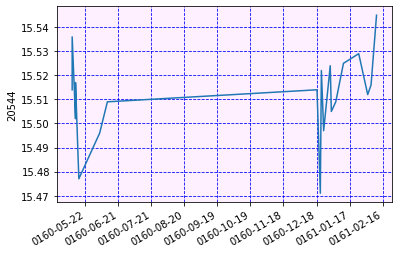

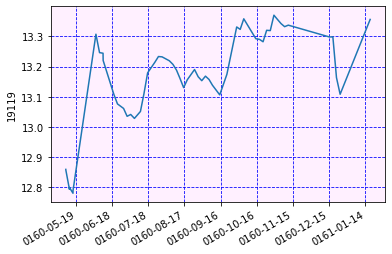

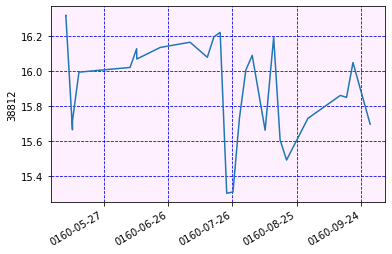

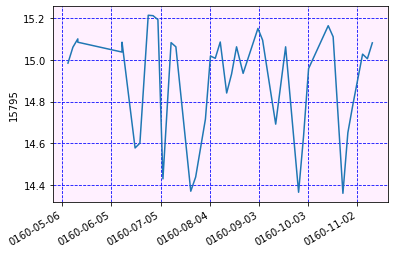

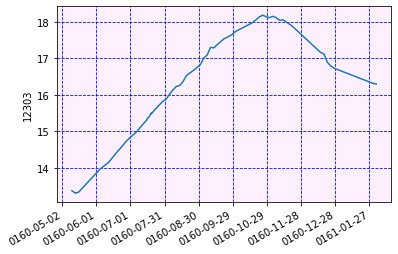

In [515]:
import random
from os import path
import matplotlib.backends.backend_pdf
import matplotlib.dates as mdates
outpath = "path/of/your/folder/"
n=1
pdf = matplotlib.backends.backend_pdf.PdfPages(str(n)+".pdf")
names=random.sample(df1[df1['Num']==n]['Name'].tolist(), 5)
for item in names:
    with open(r"C:\Users\rtut6\Desktop\Backup\2\{}.txt".format(item)) as file:
        res = file.read().replace("'", '"')
        res=json.loads(res)
    x=[]
    y=[]
    
    for i in range(len(res[list(res.keys())[0]]['lc'])):
        x.append(res[list(res.keys())[0]]['lc'][i]['mjd'])
        y.append(res[list(res.keys())[0]]['lc'][i]['mag'])


#         days = mdates.drange(start,end,dt.timedelta(days=1))
    f=plt.figure()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
    ax = plt.gca()
    ax.set_facecolor((1.0, 0.94, 1))
    plt.plot(x,y)
    plt.gcf().autofmt_xdate()
    plt.ylabel(item)
    plt.grid(True,color='blue',linestyle="--")
    pdf.savefig(f) #saving pdf
    plt.show()
pdf.close()

In [463]:
with open(r"C:\Users\rtut6\Desktop\Backup\1\11619.txt".format(item)) as file: 
    res = file.read().replace("'", '"')
    res=json.loads(res)

In [464]:
x=[]
y=[]
for i in range(len(res[list(res.keys())[0]]['lc'])):
    x.append(res[list(res.keys())[0]]['lc'][i]['mjd'])
    y.append(res[list(res.keys())[0]]['lc'][i]['mag'])

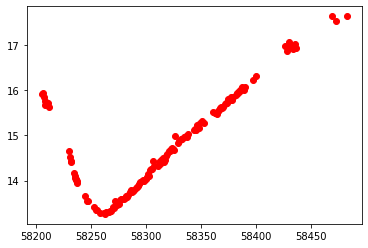

In [465]:
plt.plot(x, y, 'ro')
plt.show()

In [204]:
names=df1['Type'].value_counts()[:90].index.tolist()

In [212]:
k=0
list2=[]
df11=df1[df1['filter']=='zr']
for item in names:
    list2.append(df11[df11['Type']==item]['Nobs'].sum()/df11[df11['Type']==item].shape[0])
    k=k+1
# df1[df1['filter']]=='zg'

In [256]:
# obs=pd.DataFrame(list(zip(names,list1, list2)),columns=['Type','zg','zr'])
# obs['Type']=names
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages('12'+".pdf")
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
f=obs.fig( kind='bar')
pdf.savefig( f ) #saving pdf
pdf.close()

TypeError: 'Figure' object is not callable

In [322]:
df1

,ra,dec_x,Nobs,filter,coord,Type,dec_y
0,11.829,32.6856,45,zg,004718.91 +324108.8,M,32.685778
1,11.829,32.6856,50,zg,004718.91 +324108.8,M,32.685778
2,348.615,42.0207,47,zg,231427.64 +420114.9,E,42.020806
3,348.615,42.0207,56,zr,231427.64 +420114.9,E,42.020806
4,182.566,27.4317,33,zg,121015.89 +272554.0,RRAB,27.431667
...,...,...,...,...,...,...,...
38204,23.568,-7.41059,26,zg,013416.34 -072438.0,EW,-7.410556
38205,39.699,-5.44741,31,zg,023847.84 -052651.1,SR,-5.447528
38206,89.211,-27.667,11,zg,055650.60 -274001.6,RRAB,-27.667111
38207,89.283,-27.6421,11,zg,055707.91 -273831.5,EW,-27.642083


In [323]:
dfff=df1[df1['filter']=='zg']['Type'].value_counts()

In [324]:
dfff

M           3014
RRAB        2721
EW          1550
LB          1223
EA          1212
            ... 
INSB(YY)       1
NB+EA          1
RPHS+ELL       1
E/KW           1
X+E            1
Name: Type, Length: 199, dtype: int64

In [325]:
dfff0

,name,zg,zr
M,M,3014,2830
RRAB,RRAB,2721,2362
EW,EW,1550,1362
LB,LB,1223,1023
EA,EA,1212,792
...,...,...,...
CEP(B),CEP(B),5,4
EW:/KE,EW:/KE,5,3
ZZ,ZZ,4,3
E/RS,E/RS,4,3


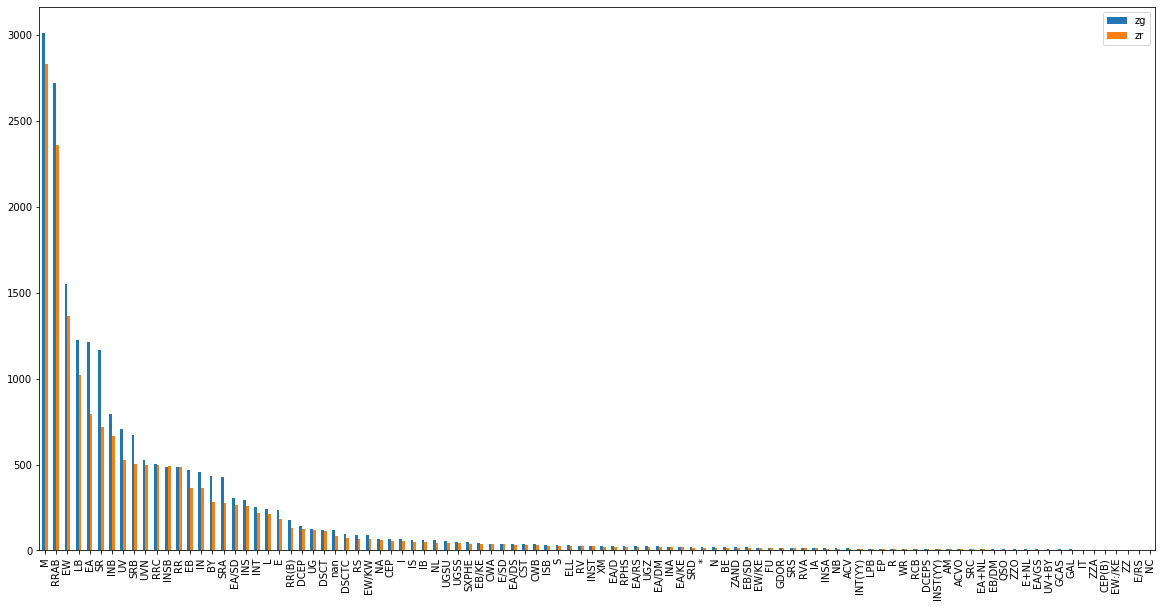

In [320]:
# obs.plot(kind='bar',figsize=(20,10))
# plt.savefig('f.png')
dfff0=pd.DataFrame(list(zip(dfff.index.tolist(),df1[df1['filter']=='zg']['Type'].value_counts().tolist(),df1[df1['filter']=='zr']['Type'].value_counts().tolist())),columns=['name','zg','zr'])
# dfff=df1['Type'].value_counts()[:100]
dfff0.index=dfff.index.tolist()
dfff0.plot(kind='bar',figsize=(20,10))

In [217]:
for i in range(obs.shape[0]):
    obs['zg'][i]=int(obs['zg'][i])
    obs['zr'][i]=int(obs['zr'][i])

C:\Users\rtut6\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\rtut6\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [94]:
for i in range(len(listl)):
    listl[i]=listl[i]*3600


Text(0.5, 1.0, 'Distribution for distances in ZTF for answers with 2 id (between ids), r=1.5arcsec')

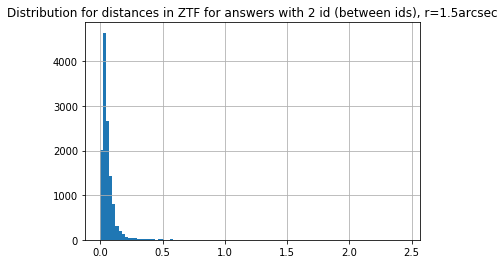

In [183]:
df=pd.DataFrame(index=range(len(listl)),columns=['degr'])
df['degr']=listl
df.hist(bins=100)
np.cumsum(a)
plt.title ("Distribution for distances in ZTF for answers with 2 id (between ids), r=1.5arcsec") #данные по всему каталогу 

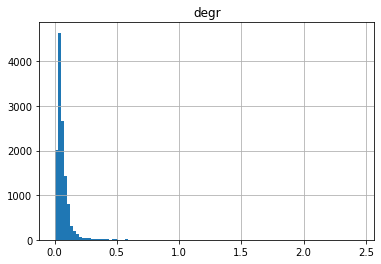

In [198]:
listrrr=df.hist(bins=100).tolist()

In [200]:
listrrr

[[<matplotlib.axes._subplots.AxesSubplot at 0x227850e9400>]]

In [68]:
# write:
# with open('2id.csv', 'wb') as f:
#     pickle.dump(list2, f)
# read:
import pickle
with open('2id.csv', 'rb') as f:
    my_list = pickle.load(f)

In [75]:
my_list[23450]

In [65]:
res = json.load(open(r"C:\Users\rtut6\Desktop\Backup\356114100000494.txt"))
res.keys()
# res1=res
# res = json.load(open(r"C:\Users\rtut6\Desktop\Backup\3356214100001202.txt"))
# res2=res

dict_keys(['356114100000494', '356214100001202', '408104400003291', '408204400005047'])

In [67]:
res = json.load(open(r"C:\Users\rtut6\Desktop\Backup\408104400003291.txt"))
res.keys()

dict_keys(['356114100000494', '356214100001202', '408104400003291', '408204400005047'])

In [129]:
list2=[None]*30000
import pickle
with open('2ID.txt', 'wb') as f:
    pickle.dump(list2, f)

In [ ]:
# #loop for uploading all the txt files
# file1 = open(r"C:\Users\rtut6\Desktop\Backup\246114400005055.txt")
# d = {}
# with open(r"C:\Users\rtut6\Desktop\Backup\246114400005055.txt") as f:
#     for line in f:
#         (key, val) = line.split()
#         d[int(key)] = val
# for i range(43000)
# for names:

# let's create a df for 4ID, for 2ID, for 1ID, 3ID, 6ID
# list4=[None]*10000
# k=0
# for item in names:
#     d2 = json.load(open(r"C:\Users\rtut6\Desktop\Backup\{}.txt".format(item)))
#     if len(d2.keys())==4:
#         list4[k]=item
#         k=k+1
#         if k % 1000==0:
#             print(k)
# k=0


listtt=[]
for item in my_list:
    try:
        res = json.load(open(r"C:\Users\rtut6\Desktop\Backup\{}.txt".format(item)))
        c1=SkyCoord(res[list(res.keys())[0]]['meta']['coord']['ra']*u.degree, res[list(res.keys())[0]]['meta']['coord']['dec']*u.degree)
        c2=SkyCoord(res[list(res.keys())[1]]['meta']['coord']['ra']*u.degree, res[list(res.keys())[1]]['meta']['coord']['dec']*u.degree)
    #     c3=SkyCoord(res[list(res.keys())[2]]['meta']['coord']['ra']*u.degree, res[list(res.keys())[2]]['meta']['coord']['dec']*u.degree)
    #     c4=SkyCoord(res[list(res.keys())[3]]['meta']['coord']['ra']*u.degree, res[list(res.keys())[3]]['meta']['coord']['dec']*u.degree)
        sep1 = c1.separation(c2)*u.degree
    #     sep2 = c2.separation(c3)*u.degree
    #     sep3 = c3.separation(c4)*u.degree
    #     sep4 = c2.separation(c4)*u.degree
    #     sep5 = c1.separation(c4)*u.degree
    #     sep6 = c1.separation(c3)*u.degree
        listtt.append(sep1)
    except:
        print('1')
#     if sep1.value>e or sep2.value>e or sep3.value>e or sep4.value>e or sep5.value>e or sep6.value>e:
#         list41[k]=item
#         k=k+1
# df=pd.DataFrame(columns=['Nid','n_obs','filter','',''])        
# df.head()        
# list4
# print(type(d2))


1
1
1


In [75]:
listtt1=[]
for i in range(len(listtt)):
    listtt1.append(listtt[i].value)

In [191]:
len(special)

91

In [89]:
df = pd.Series( (v for v in listtt1) )

In [97]:
df.to_csv('2iddist.csv')

C:\Users\rtut6\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Distribution for distances in ZTF for answers with 2 id (between ids), r=5arcsec')

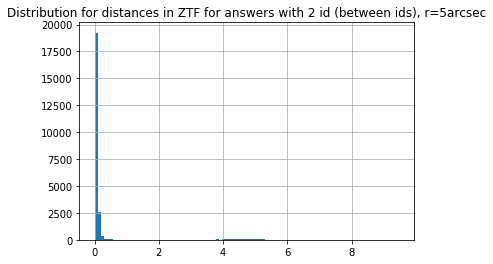

In [96]:
df.hist(bins=100)
plt.title ("Distribution for distances in ZTF for answers with 2 id (between ids), r=5arcsec") #данные по всему каталогу 

In [32]:
sep1 = c1.separation(c2)*u.degree
print(sep1.value)
print(e)

NameError: name 'c1' is not defined

In [136]:
d2 = json.load(open(r"C:\Users\rtut6\Desktop\Backup\331108400001709.txt"))
print(d2.keys())

dict_keys(['331108400001709', '331108400118530', '331208400001216', '331208400178321'])


In [87]:
my_data['dist1']=0
for i in range(1,1282):
    my_data['dist1'][i]=my_data['dist'][i]*3600
my_data.hist(column="dist1")
#распределение по расстоянию для ответов с 2ID (3000 рандомных запрсов)
plt.title ("распределение по расстоянию для ответов с 2ID (3000 рандомных запрсов)") # данные для 3000 рандомных запросов

NameError: name 'my_data' is not defined

In [190]:
# my_data.head(20)
# my_data['idN'].value_counts().nlargest(n=5)  # пять самых больших классов
labels = '2.0 ID', '4.0 ID', '1.0 ID', '3.0 ID','6.0 ID'
sizes = [12580, 1610, 5330, 273,49] # Размеры пяти самых больших классов
# sizes = [ , , 4973, ,]
# colors = ['yellow', 'blue', 'pink', 'green','red']
# explode = (0.1, 0, 0, 0)  # explode 1st slice
# # Plot
# plt.pie(sizes, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140)
# plt.axis('equal')
# plt.title ("Процентное оотношение API-ответов с различным числом ID") # данные для 3000 рандомных запросов
# plt.show()

import plotly.express as px
# df = px.data.gapminder().query("year == 2007").query("continent == 'Europe'")
# df.loc[df[''] < 2.e6, 'country'] = 'Other countries' # Represent only large countries
fig = px.pie(sizes, values=sizes, names=labels, title='ID distribution')
fig.show()


Text(0.5, 1.0, 'Distribution for distances in GCVS-ZTF for answers with 1 ID, r=5arcsec')

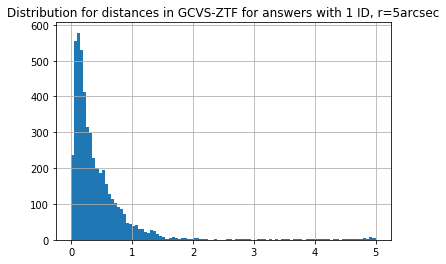

In [100]:
df = pd.read_csv(r'1IDobj.csv',sep='\t')
df['dist1']=df['dist1']
df['dist1'].hist(bins=100)
plt.title ("Distribution for distances in GCVS-ZTF for answers with 1 ID, r=5arcsec") #данные по всему каталогу 

In [101]:
df.shape

(4973, 8)

In [ ]:
df['class'].hist()

In [ ]:
my_data.to_csv('1IDobj-.csv', sep='\t')

In [ ]:
# оставляем только популярные классы

In [ ]:
largest_classes = list(df['class'].value_counts().nlargest(n=150).index)

In [ ]:
av=[None]*100
for i in range(0,100):
    S=0
    for j in range(4973):
        if df['class'][j]==largest_classes[i]:
            S=S+df['pointsN'][j]
    av[i]=S/k[i]
print(int(av)        
    

In [ ]:
distr=pd.DataFrame(av, columns=['dist'])
distr=pd.DataFrame(largest_classes, columns=['class'])

In [ ]:
# Create a zipped list of tuples from above lists
zippedList =  list(zip(largest_classes, av))
# Create a dataframe from zipped list
dfObj = pd.DataFrame(zippedList, columns = ['Class' , 'Av']) 

In [ ]:
for i in range(0,100):
    dfObj['Av'][i]=int(dfObj['Av'][i])

In [ ]:
pd.set_option('display.max_rows', dfObj.shape[0]+1)
print(dfObj)

In [ ]:
to_replace = list(set(df['class'].values) - set(largest_classes))

In [ ]:
df['class'].replace(list(to_replace), 'OTHER', inplace=True)

In [ ]:

plt.plot(data['Year'], data['Student'], label=region)

plt.xlabel('Year')
plt.ylabel('Number of Students')
plt.legend()
plt.show()

In [137]:
dfff=pd.DataFrame(columns=['Type','N'])
dfff=df11['Type'].value_counts()[:30]
# df22=df11['Type'].value_counts()[:76]

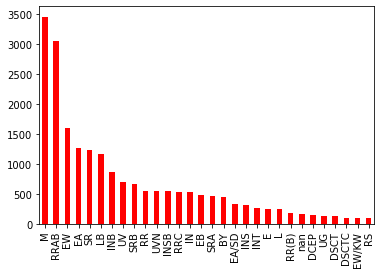

In [138]:
dfff.plot(kind='bar', color=['red'])

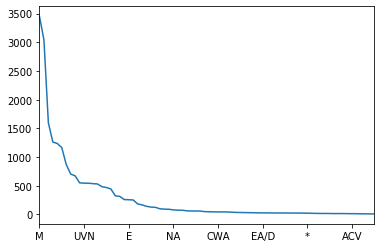

In [124]:
df22.plot()
# plot.show()

In [ ]:
k=[None]*100
k=list(df['Type'].value_counts().nlargest(n=100))

In [ ]:
len(largest_classes)

# Machine Learning 

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split
# from xgboost import XGBClassifier
# from sklearn.metrics import average_precision_score
# from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import roc_curve, auc,recall_score,precision_score
# from sklearn.metrics import accuracy_score

In [ ]:
# data1=df.drop(['filter','obj_id'], axis=1)

In [ ]:
# RandomForestClassifier

In [ ]:
# df1=df.iloc[1500:1725]
# array = data1.values
# X = array[:,0:7]
# Y = array[:,7]
# validation_size = 0.2
# seed = 5
# X_train=X[0:1500]
# X_validation=X[1500:1725]
# Y_train=Y[0:1500]
# Y_validation=Y[1500:1725]
# X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)
# X_train1, X_testt, Y_train1, Y_testt = train_test_split(X_train, Y_train, test_size=validation_size1, random_state=seed)
# print(Y)
# train.head()

In [ ]:
#Learning with XGB model
# model = XGBClassifier(random_state=34, seed=7, colsample_bytree=0.8, subsample=0.6, n_estimators=2000)
# model.fit(X_train,Y_train)
# pred = model.predict(X_validation)
# accuracy = accuracy_score(Y_validation, pred)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
# df1['pred']=pred
# df1.head(1000)

In [ ]:
# plt.figure(figsize=(10,5))
# plt.plot(np.array(obj_mjd1[9]), np.array(obj_mag1[9]))

In [ ]:
# obj_mag